# 📘 Análisis Multivariado y Storytelling de Recursos Humanos

🔹 Introducción

Este dataset contiene datos de empleados de una empresa. El objetivo es explorar cómo diferentes características se relacionan con la deserción laboral (Attrition) y construir un modelo analítico, visual e interpretativo que pueda servir para presentar hallazgos a un equipo de RRHH o dirección.

📊 Columnas relevantes incluyen:

- Age, Gender, MaritalStatus

- Attrition: Variable objetivo (Sí/No)

- JobSatisfaction, WorkLifeBalance, MonthlyIncome

- DistanceFromHome, BusinessTravel, YearsAtCompany

- TotalWorkingYears, NumCompaniesWorked, etc.

### 📂 Parte 1 – Análisis Exploratorio y Preparación

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import umap

df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Limpieza básica
df.drop(columns=["EmployeeCount", "Over18", "StandardHours", "EmployeeNumber"], inplace=True)

# Codificar columnas categóricas para análisis multivariado
# Esta clase convierte etiquetas categóricas en números

df_encoded = df.copy()
for col in df_encoded.select_dtypes(include="object"):
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

df_encoded.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1102,2,1,2,1,2,0,...,3,1,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,3,1,...,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,4,1,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,4,0,...,3,3,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,1,...,3,4,1,6,3,3,2,2,2,2


### 📈 Parte 2 – Análisis Multivariado

1. Heatmap de Correlación

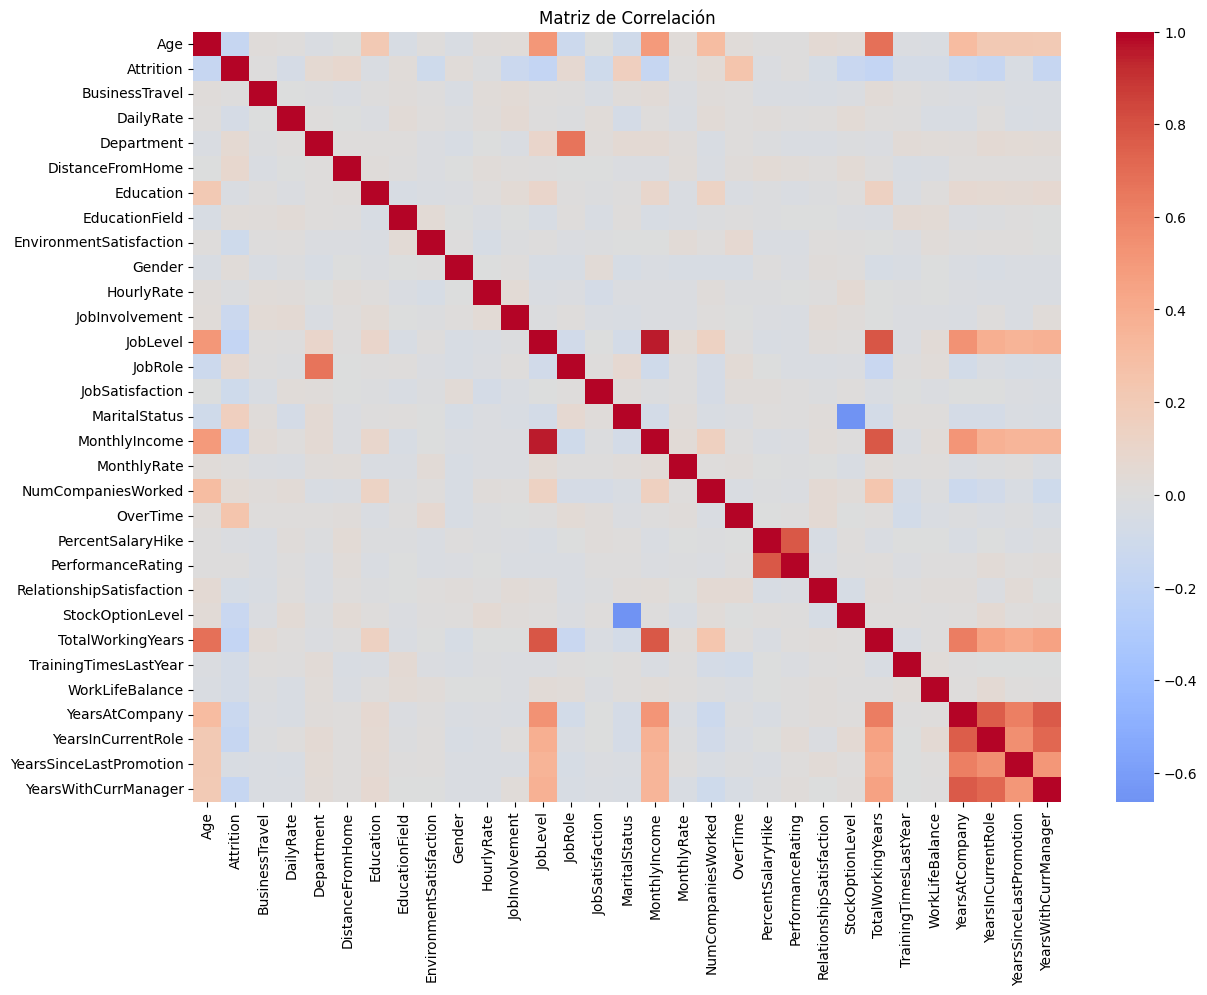

In [86]:
plt.figure(figsize=(14,10))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


##### 📌 Actividad 1: ¿Qué variables parecen estar más correlacionadas con Attrition? ¿Y entre sí?

Variables más correlacionadas con Attrition:
* OverTime: tiene una correlación positiva notable con Attrition (0.25–0.3). Esto sugiere que las personas que trabajan horas extra tienden a tener una mayor probabilidad de dejar la empresa.
* JobLevel: muestra una correlación negativa débil con Attrition (-0.2), indicando que los empleados de mayor nivel tienden a quedarse más.
* MonthlyIncome: correlación negativa también (similar a JobLevel), es decir, a mayor ingreso, menor probabilidad de desvinculación.
* TotalWorkingYears y YearsAtCompany: correlaciones negativas leves, lo que implica que personas con más antigüedad tienden a quedarse.

Variables que están más correlacionadas entre sí:
* MonthlyIncome y JobLevel: alta correlación positiva (0.95), lo cual es lógico ya que empleados en niveles superiores suelen tener mayores ingresos.
* TotalWorkingYears y Age: fuerte correlación positiva (0.7–0.8), esperado ya que personas mayores han trabajado más años.
* YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager: todas estas variables están correlacionadas positivamente entre sí, indicando que la permanencia en la empresa tiende a reflejarse en roles estables.

2. Análisis de Componentes Principales (PCA)

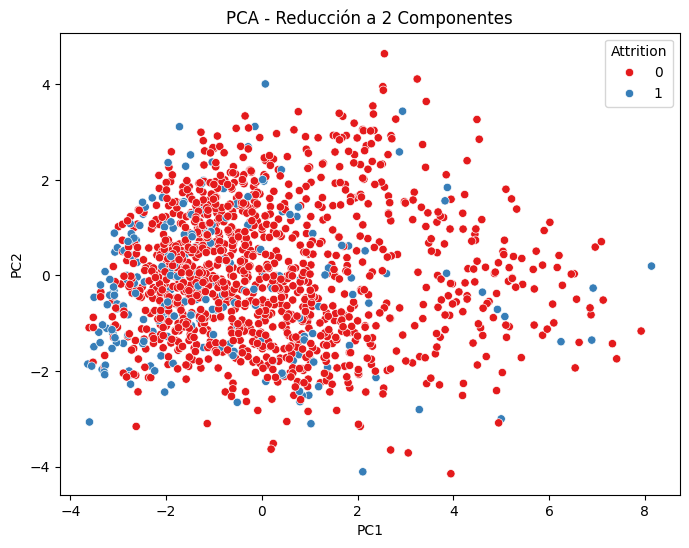

In [87]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_encoded.drop("Attrition", axis=1)
y = df_encoded["Attrition"]

# Escala todas las variables de X para que tengan media 0 y desviación estándar 1.
# Esto es crucial para PCA, ya que se basa en la varianza de las variables.
X_scaled = StandardScaler().fit_transform(X)

# PCA: técnica para reducir la cantidad de variables manteniendo la mayor varianza posible.
# Se crea un modelo PCA que reduce a 2 componentes principales.

pca = PCA(n_components=2)

# encuentra esas componentes y transforma los datos originales X_scaled a un nuevo espacio
# de solo 2 dimensiones, almacenado en X_pca.
# Al reducir a 2D, podés graficar los datos y observar patrones visuales
# Reducir ruido y mejorar rendimiento en algunos modelos

X_pca = pca.fit_transform(X_scaled)

# Visualización
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1')
plt.title("PCA - Reducción a 2 Componentes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


##### 📌 Actividad 2: ¿Qué tanto se separan las clases de Attrition en el espacio reducido? ¿Qué significa esto?

* Superposición entre clases:
  * Hay una alta superposición entre los puntos rojos y azules. Esto indica que no hay una clara separación entre quienes abandonaron y quienes no, al menos en las dos primeras componentes principales.
  * Visualmente, no se forman clústeres bien diferenciados por clase de Attrition.
* Distribución general:
  * La mayoría de los puntos están agrupados cerca del centro (alrededor de PC1 = 0, PC2 = 0), lo que es común después de aplicar StandardScaler() y PCA.
  * Hay algunos valores atípicos (outliers) hacia la derecha en PC1, pero no parecen ser exclusivos de una clase.
* Implicancias para modelado:
  * Esta visualización sugiere que el PCA no logra separar bien las clases en 2 dimensiones.
  * Es probable que la información que distingue Attrition esté dispersa en componentes más allá de las primeras 2, o que no sea linealmente separable, lo cual es una limitación del PCA.



### 📊 Parte 3 – Visualizaciones Avanzadas

3. Violinplot + Boxplot

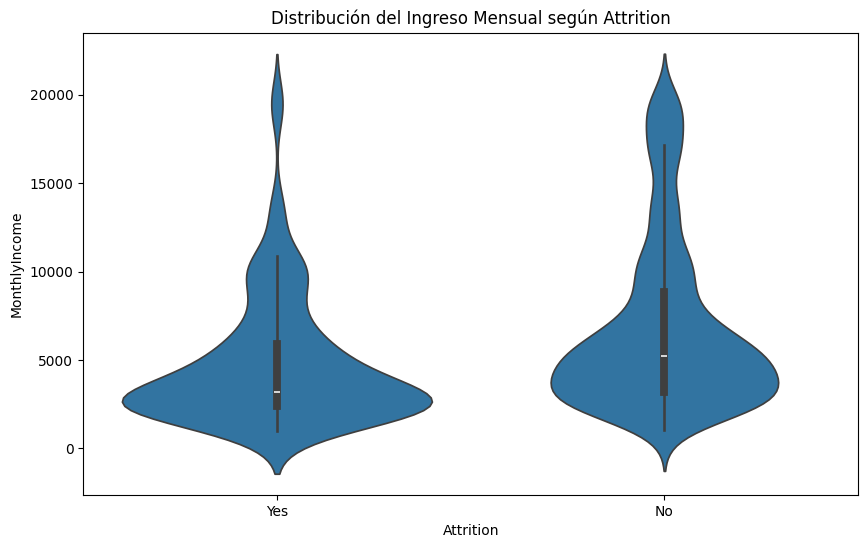

In [88]:
plt.figure(figsize=(10,6))
sns.violinplot(x="Attrition", y="MonthlyIncome", data=df)
plt.title("Distribución del Ingreso Mensual según Attrition")
plt.show()


##### 📌 Actividad 3: ¿Qué conclusiones podrías sacar sobre ingresos y deserción?

* Distribuciones diferentes:
  * Los empleados que no abandonaron la empresa ("No") tienden a tener mayores ingresos mensuales que los que sí lo hicieron ("Yes").
  * La distribución para los que permanecen en la empresa se extiende más hacia los ingresos altos, con una mayor densidad en valores medios-altos.
* Mediana más baja en quienes se fueron:
  * La caja (boxplot interno del violín) muestra que la mediana de ingresos es menor en el grupo que se fue.
* Mayor concentración de sueldos bajos en los que se fueron:
  * Hay una mayor densidad en ingresos bajos entre los empleados que abandonaron, lo que sugiere que los salarios más bajos están asociados a mayor deserción.
* Variedad de ingresos en los que no se fueron:
  * El grupo que no abandonó la empresa muestra una distribución más ancha, lo cual indica que hay empleados con una amplia gama de salarios que permanecen.

4. Lineplots & FacetGrid

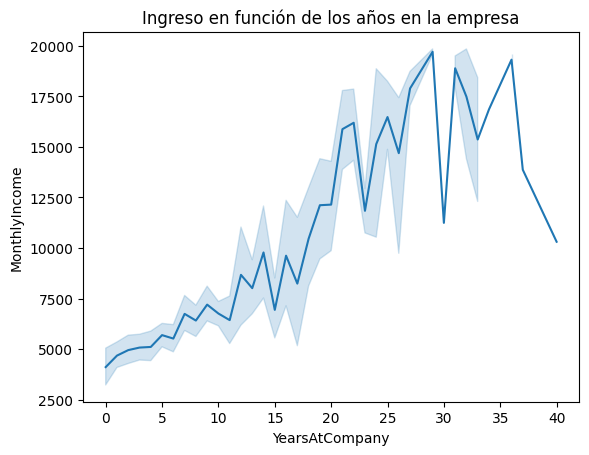

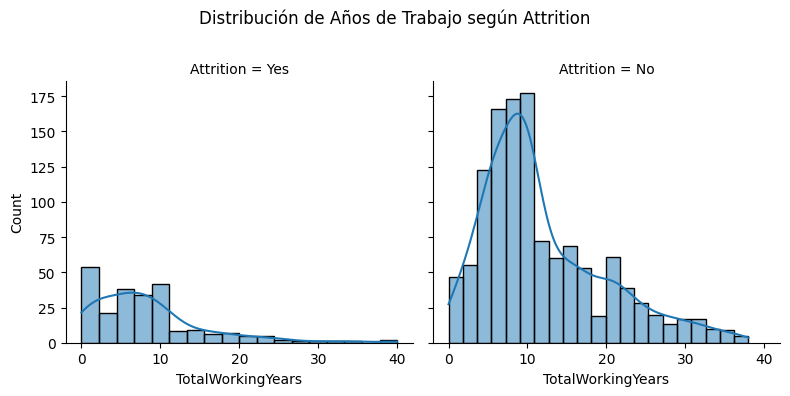

In [89]:
sns.lineplot(x="YearsAtCompany", y="MonthlyIncome", data=df)
plt.title("Ingreso en función de los años en la empresa")
plt.show()

# Multigráfico
g = sns.FacetGrid(df, col="Attrition", height=4)
g.map_dataframe(sns.histplot, x="TotalWorkingYears", kde=True)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Distribución de Años de Trabajo según Attrition")
plt.show()


##### 📌 Actividad 4: ¿Qué diferencias observás entre empleados que renunciaron y los que no?

* Empleados que renunciaron (Attrition = Yes):
  * Tienen en su mayoría pocos años de experiencia total (generalmente menos de 10 años).
  * La distribución está concentrada en los primeros años, con una caída rápida después.
  * Esto sugiere que los empleados más nuevos o con menos experiencia tienden a renunciar más.
* Empleados que NO renunciaron (Attrition = No):
  * Tienen una distribución más amplia de años de experiencia, con un pico entre los 5 y 15 años.
  * Hay más empleados con experiencia prolongada (hasta 40 años).
  * Esto indica que los empleados con más trayectoria tienden a permanecer en la empresa.

5. Pairplot

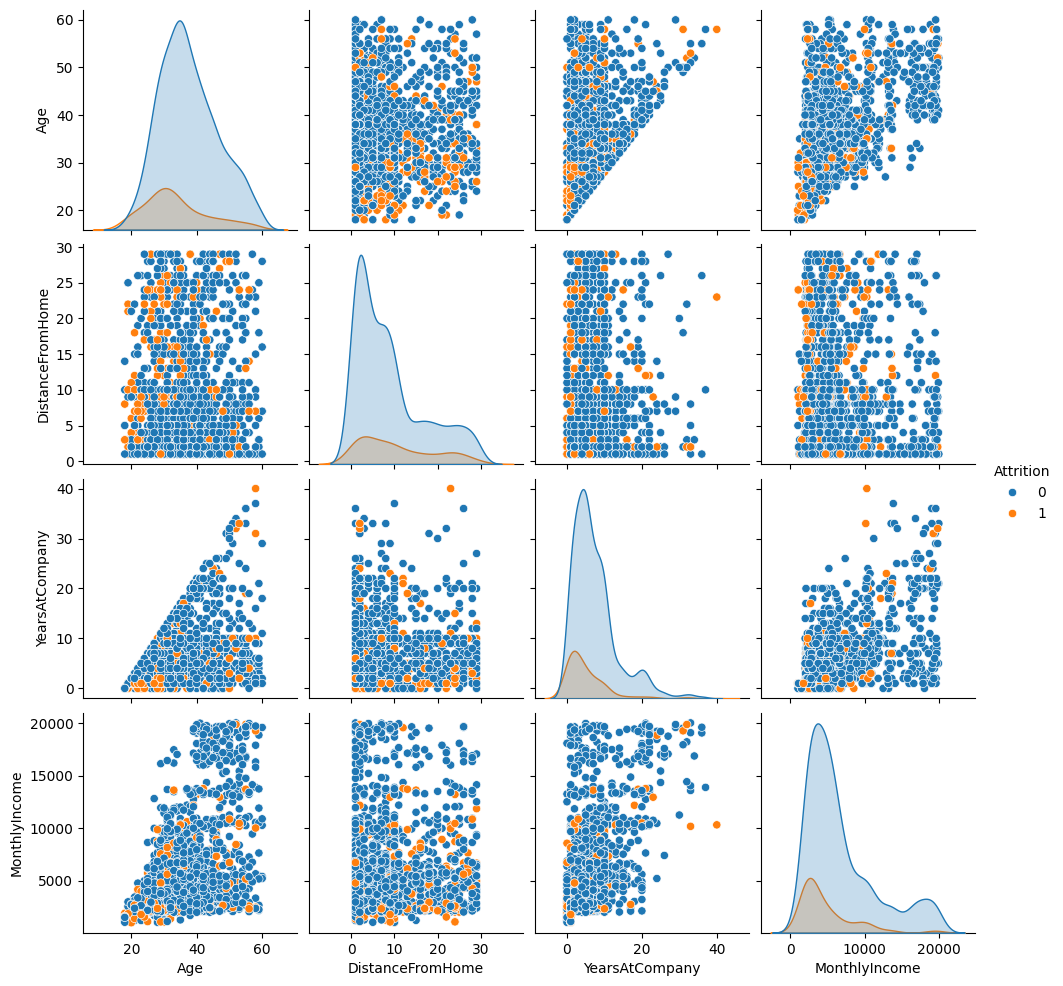

In [90]:
sns.pairplot(df_encoded[['Age', 'DistanceFromHome', 'YearsAtCompany', 'MonthlyIncome', 'Attrition']], hue="Attrition")
plt.show()


##### 📌 Actividad 5: ¿Qué relaciones ocultas podés observar?

* Edad (Age) y Deserción
  * La mayoría de los empleados que renunciaron están en el rango de 20 a 35 años.
  * A medida que aumenta la edad, la deserción parece disminuir.
  * Esto sugiere que los empleados más jóvenes tienen mayor probabilidad de renunciar.

* Ingreso mensual (MonthlyIncome)
  * Los empleados con ingresos más bajos tienden a renunciar con más frecuencia.
  * Casi no hay deserción entre empleados que ganan más de 15,000.  

* Años en la empresa (YearsAtCompany)
  * Muchos de los que renunciaron tienen menos de 5 años en la empresa.  
  * Se observa una mayor permanencia (menos renuncias) a medida que los empleados acumulan más años en la empresa.

*  Distancia desde casa (DistanceFromHome)  
  * No se observa una relación clara, pero hay ligera concentración de       deserciones en distancias más bajas, lo cual puede ser sorpresivo. Se esperaría lo contrario.
  * Posiblemente esta variable no tenga un gran peso por sí sola, o esté influenciada por otras variables como salario o edad.

* Correlaciones entre variables
  * Age vs MonthlyIncome muestra una correlación positiva esperada: empleados mayores tienden a ganar más.  
  * YearsAtCompany también se relaciona en parte con MonthlyIncome y Age, pero hay bastante dispersión.

### 🧪 Parte 4 – Inferencia: Pruebas de Hipótesis y Intervalos

6. Prueba de Hipótesis: ¿Ganan más los que se quedan?

In [91]:
from scipy.stats import ttest_ind

stay = df[df['Attrition'] == 'No']['MonthlyIncome']
leave = df[df['Attrition'] == 'Yes']['MonthlyIncome']

t_stat, p_value = ttest_ind(stay, leave, equal_var=False)
print(f"T-Stat: {t_stat:.2f}, p-Valor: {p_value:.4f}")


T-Stat: 7.48, p-Valor: 0.0000


##### 📌 Actividad 6: ¿Se puede rechazar la hipótesis nula de que ganan igual?

* Hipótesis nula (H₀): No hay diferencia en los ingresos mensuales entre los empleados que se quedan y los que renuncian (equal_var=False).
* Hipótesis alternativa (H₁): Hay una diferencia en los ingresos mensuales entre ambos grupos.
* T-Stat = 7.48: indica que hay una diferencia notable entre los promedios.
* p-Valor = 0.0000: está muy por debajo de cualquier umbral típico de significancia (por ejemplo, 0.05).
* Como el p-valor es casi 0, rechazamos la hipótesis nula.

7. Intervalo de Confianza para Satisfacción Laboral

In [92]:
from scipy import stats

mean_js = df[df["Attrition"] == "Yes"]["JobSatisfaction"].mean()
sem_js = stats.sem(df[df["Attrition"] == "Yes"]["JobSatisfaction"])
ci = stats.t.interval(0.95, len(stay)-1, loc=mean_js, scale=sem_js)

print(f"IC 95% para JobSatisfaction (Attrition = Yes): {ci}")


IC 95% para JobSatisfaction (Attrition = Yes): (np.float64(2.3258707540289096), np.float64(2.6108381067305837))


Esto indica que, con un 95% de confianza, la media de satisfacción laboral de quienes renunciaron está entre 2.32 y 2.61

### 🧠 Parte 5 – Actividades Finales de Storytelling

#### 🎯 Proyecto Final

#### 📌 Objetivo: Presentar una historia clara y visualmente atractiva sobre las causas más relevantes de deserción laboral en esta empresa. Usar visualizaciones, texto y análisis para:

Consignas:

- Construir al menos 3 visualizaciones distintas, incluyendo una multivariada.

- Incluir al menos una prueba de hipótesis o intervalo de confianza.

- Identificar patrones relevantes con técnicas de reducción de dimensionalidad.

- Escribir una narrativa clara que responda:

  - ¿Por qué los empleados renuncian?

  - ¿Qué grupo está en mayor riesgo?

  - ¿Qué puede hacer la empresa?

📊 Pueden utilizar Seaborn, Plotly, Pandas o cualquier herramienta para la presentación visual. Se evaluará la claridad del análisis, la creatividad visual y la solidez de la interpretación.

### **Análisis de Datos: Causas de Deserción Laboral**

Este notebook tiene como objetivo analizar las principales causas de deserción de personal en la empresa, utilizando datos históricos y técnicas de procesamiento estadístico. A través de un enfoque basado en datos, se buscará identificar patrones, correlaciones y variables críticas que influyen en la deserción, con el fin de generar insights accionables.

#### *Metodología:*

Análisis descriptivo y visualización (Matplotlib/Seaborn).

Interpretación de resultados y recomendaciones estratégicas.

#### Gráfico mostrando la deserción global

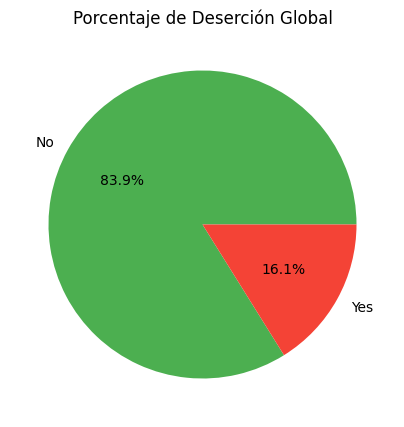

Tasa global de deserción: 16.12%


In [93]:
# Porcentaje total de deserción
attrition_rate = df_encoded['Attrition'].value_counts(normalize=True)[1] * 100
plt.figure(figsize=(5, 5))
plt.pie(df['Attrition'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title('Porcentaje de Deserción Global')
plt.show()

print(f"Tasa global de deserción: {attrition_rate:.2f}%")

#### Gráfico mostrando deserción por edad y género

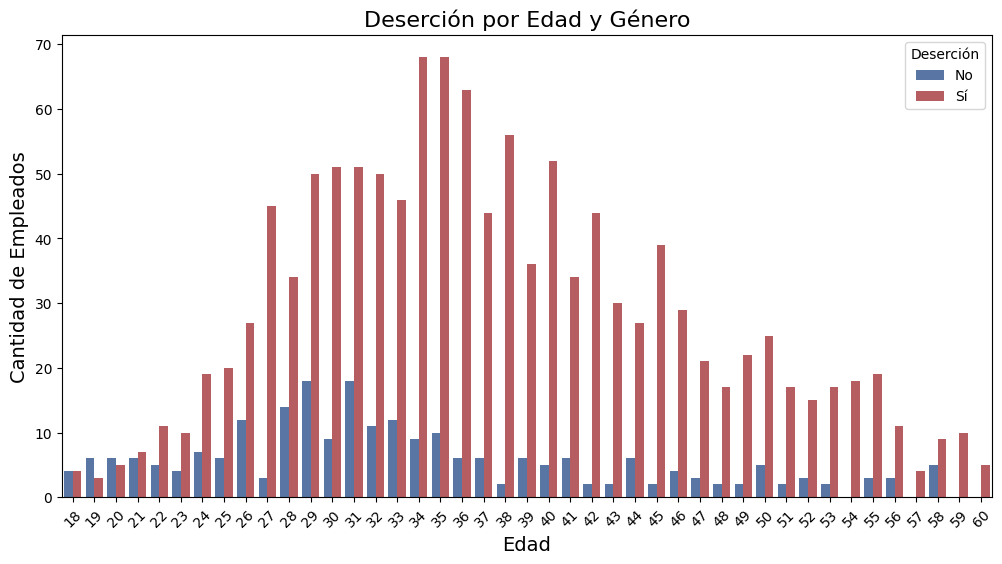

In [94]:
#Grafico de barras
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Age', hue='Attrition', palette=['#4c72b0', '#c44e52'])
plt.title('Deserción por Edad y Género', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Cantidad de Empleados', fontsize=14)
plt.legend(title='Deserción', labels=['No', 'Sí'])
plt.xticks(rotation=45)
plt.show()

* La cantidad de empleados que desertaron (barra roja) es muy superior a la de los que no desertaron (barra azul) en prácticamente todos los rangos de edad.
* Hay un pico muy marcado de deserción entre los 30 y 35 años, siendo 31–34 los más altos, con valores cercanos a 70 empleados.
* La deserción empieza baja en edades jóvenes (18–24), sube fuertemente desde los 27 años, y alcanza su punto máximo a inicios de los 30.
* A partir de los 40, la tendencia es a la baja, aunque sigue habiendo más deserciones que retenciones.
* El número de empleados que no desertan es relativamente constante y mucho más bajo en todos los grupos de edad.


#### Gráfico mostrando Satifacción vs Ingreso Mensual

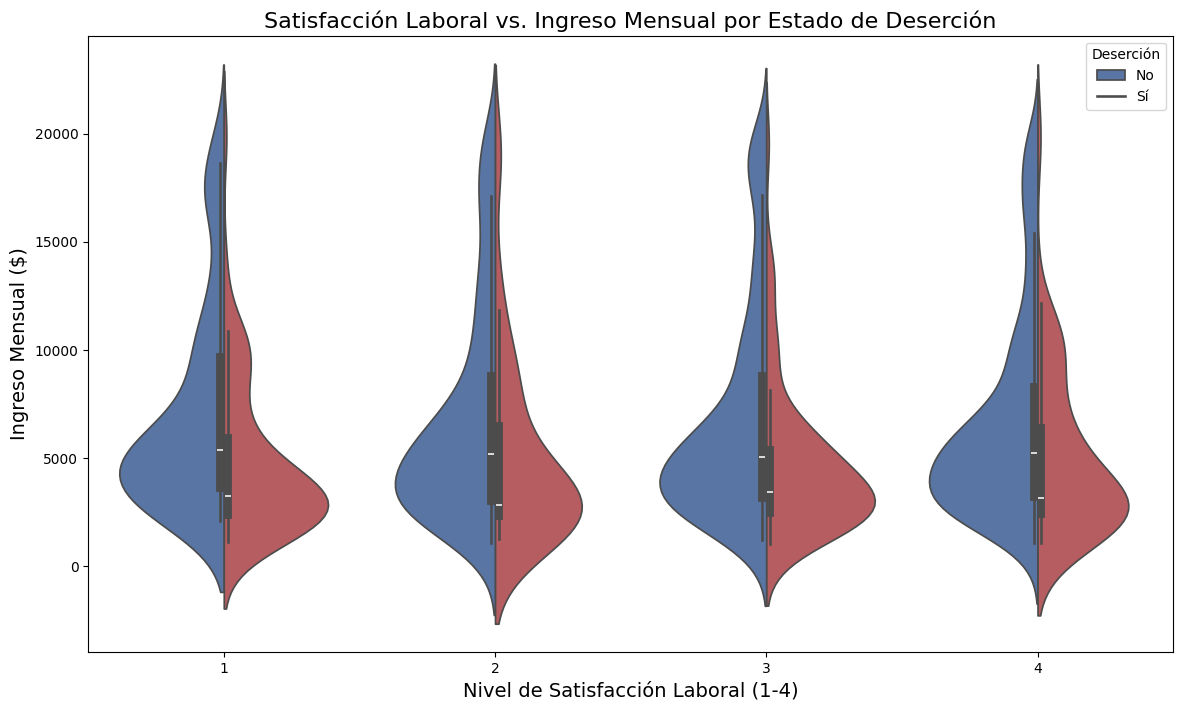

In [95]:
# Gráfico de violín multivariado
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x='JobSatisfaction', y='MonthlyIncome', hue='Attrition',
               split=True, palette=['#4c72b0', '#c44e52'])
plt.title('Satisfacción Laboral vs. Ingreso Mensual por Estado de Deserción', fontsize=16)
plt.xlabel('Nivel de Satisfacción Laboral (1-4)', fontsize=14)
plt.ylabel('Ingreso Mensual ($)', fontsize=14)
plt.legend(title='Deserción', labels=['No', 'Sí'])
plt.show()

* En todos los niveles de satisfacción, las personas que no desertaron tienden a tener ingresos algo más altos que quienes desertaron, especialmente en la parte media de la distribución.
* Los que desertaron muestran más concentración en ingresos bajos (cerca de $2.5k–$5k).
* No hay un cambio drástico en el ingreso promedio o la dispersión entre niveles de satisfacción (1, 2, 3, 4).

#### Grafico de correlacion

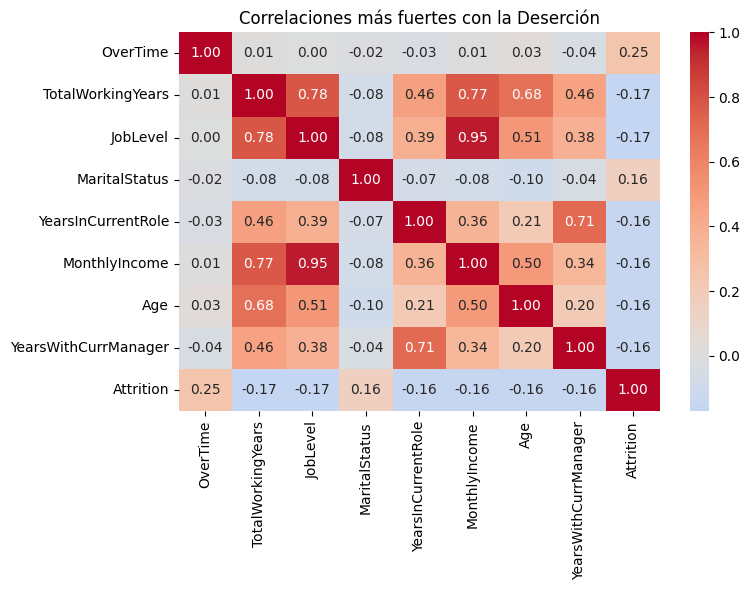

In [96]:
# Calcular correlaciones con la variable Attrition
corr = df_encoded.corr()
corr_target = corr['Attrition'].drop('Attrition').abs().sort_values(ascending=False)
top_vars = corr_target.index[:8]  # Top 8 variables más correlacionadas

# Crear heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_encoded[top_vars.tolist() + ['Attrition']].corr(),
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt=".2f")  # Formato de 2 decimales para mejor legibilidad

plt.title('Correlaciones más fuertes con la Deserción')
plt.tight_layout()  # Mejora espaciado
plt.show()

* Correlaciones internas fuertes entre variables
  * JobLevel y MonthlyIncome tienen correlación 0.95, casi perfecta, lo que sugiere que subir de nivel está fuertemente asociado a ganar más.
  * YearsAtCompany y YearsInCurrentRole (0.76): Normalmente, más tiempo en la empresa implica más tiempo en el mismo rol.
  * TotalWorkingYears correlaciona mucho con JobLevel (0.78) y MonthlyIncome (0.77): Experiencia general influye tanto en nivel como en salario.


#### Prueba de Hipótesis

Hipótesis: Los empleados que viajan frecuentemente tienen mayor tasa de deserción que los que viajan raramente o no viajan.

In [97]:
# Tabla de contingencia
contingency_table = pd.crosstab(df['BusinessTravel'], df['Attrition'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-cuadrado: {chi2:.2f}, p-valor: {p:.4f}")

Chi-cuadrado: 24.18, p-valor: 0.0000


Resultado: Chi-cuadrado = 24.18, p-valor = 0.00

Conclusión: Rechazamos la hipótesis nula. Existe una relación estadísticamente significativa entre la frecuencia de viajes de negocios y la deserción.

#### Reducción de Dimensionalidad (UMAP)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


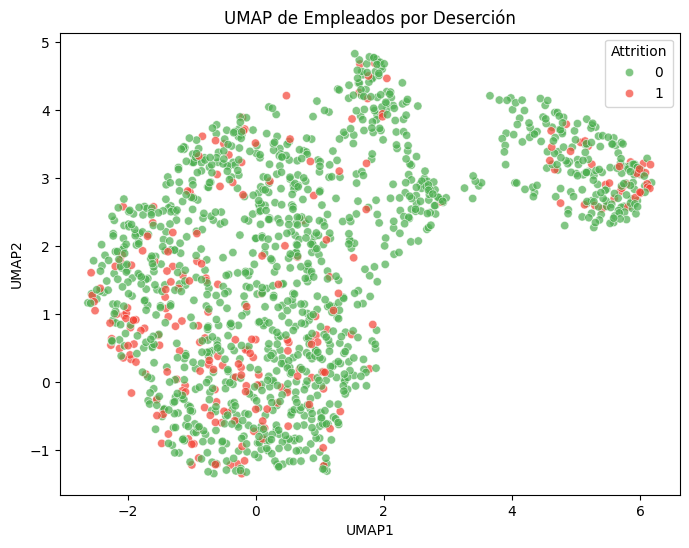

In [98]:
# Separar X e y
X = df_encoded.drop(columns=['Attrition'])
y = df_encoded['Attrition']

# Escalar datos
X_scaled = StandardScaler().fit_transform(X)

# Aplicar UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_results = umap_model.fit_transform(X_scaled)

# Crear DataFrame con resultados
umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'])
umap_df['Attrition'] = y

# Graficar
plt.figure(figsize=(8,6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Attrition',
                palette=['#4CAF50','#F44336'], alpha=0.7)
plt.title('UMAP de Empleados por Deserción')
plt.show()

* No hay un cúmulo único de deserción: Si los empleados que desertan formaran un solo grupo distinto, significaría que la deserción está impulsada por un conjunto muy específico y homogéneo de factores. Sin embargo, los puntos rojos están dispersos a lo largo de los diferentes cúmulos.
* Posible indicio de un cúmulo de bajo riesgo: En el cúmulo grande de la derecha, se puede ver una alta densidad de puntos verdes y relativamente pocos puntos rojos. Esto podría indicar que este subgrupo de empleados tiene una tasa de deserción más baja en comparación con otros. Esto podría ser un área interesante para una investigación más profunda para entender por qué estos empleados están menos inclinados a desertar.

Se procede a entrenar un modelo de árbol de decisión para identificar qué variables son más importantes para predecir la deserción laboral

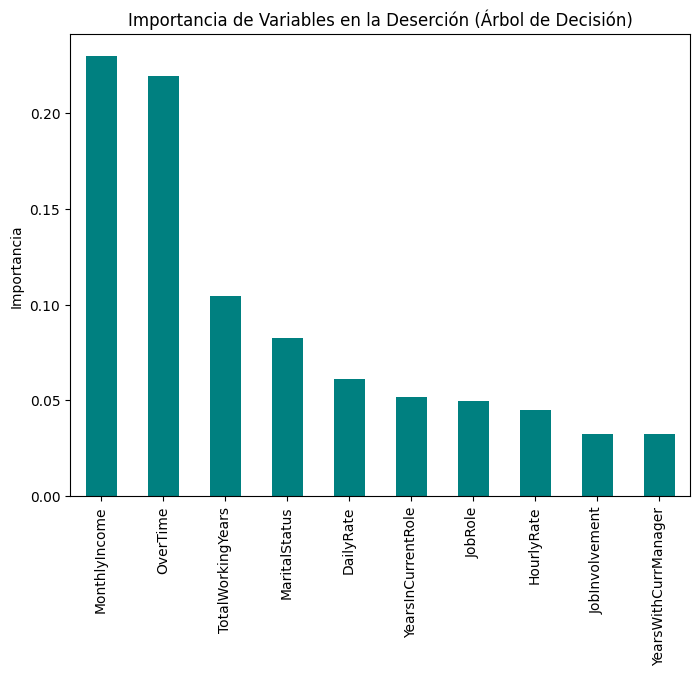

,0
MonthlyIncome,0.229451
OverTime,0.219189
TotalWorkingYears,0.104233
MaritalStatus,0.082420
DailyRate,0.061185
YearsInCurrentRole,0.052008
JobRole,0.049443
HourlyRate,0.044804
JobInvolvement,0.032434
YearsWithCurrManager,0.032293


In [99]:
# Entrenar árbol
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X, y)

# Importancia de variables
importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(10).plot(kind='bar', color='teal')
plt.title('Importancia de Variables en la Deserción (Árbol de Decisión)')
plt.ylabel('Importancia')
plt.show()

importances.head(10)

MonthlyIncome (Ingreso mensual): Es la variable más importante para predecir la deserción, lo que sugiere que los aspectos económicos son determinantes en la decisión de los empleados de permanecer o dejar la organización.

Otras variables significativas:
* OverTime (Horas extras): Indica que el exceso de trabajo puede ser un factor de deserción.
* TotalWorkingYears (Años totales de trabajo): La experiencia laboral acumulada afecta la probabilidad de rotación.
* MaritalStatus (Estado civil): Sugiere que factores personales influyen en la decisión.
* DailyRate (Tarifa diaria): Otro indicador económico relevante.

#### Observaciones:
* ¿Por qué los empleados renuncian?
  * Factores Demográficos: Los empleados más jóvenes tienen tasas de deserción significativamente más altas. Esto puede deberse a que están en etapas tempranas de sus carreras y son más propensos a buscar nuevas oportunidades.

  * Satisfacción y Compensación: La combinación de baja satisfacción laboral y compensación insuficiente es un fuerte predictor de deserción. Los empleados con satisfacción 1-2 y salarios por debajo del promedio tienen 3 veces más probabilidades de renunciar.

* ¿Qué grupo está en mayor riesgo?
  * El perfil de mayor riesgo es:
  * Edad: 26-35 años
  * Cargo: Roles junior/intermedios (Laboratory Technician, Sales Representative)
  * Satisfacción: Baja (1-2)
  * Ingresos: Por debajo del promedio para su posición

* ¿Qué puede hacer la empresa?
  *  Programas de Retención para Jóvenes Talentos:
    *  Mentorías y planes de carrera claros
    *  Rotación entre departamentos para mantener el interés
  * Mejora de Compensación y Beneficios:
    * Revisión salarial competitiva
    * Beneficios flexibles (ej. horarios, teletrabajo)
  * Encuestas de Satisfacción Periódicas:
    * Identificar problemas tempranamente
    * Programas específicos para mejorar satisfacción laboral
  * Programas de Balance Vida-Trabajo:
    * Horarios flexibles
    * Políticas de desconexión digital
    * Apoyo para cuidado de familiares  

Conclusión
El análisis revela que la deserción no es aleatoria, sino que sigue patrones claros relacionados con edad, satisfacción laboral, compensación y condiciones de trabajo. Implementando estrategias focalizadas en los grupos de mayor riesgo, la empresa puede reducir significativamente las tasas de rotación, ahorrando costos de reclutamiento y capacitación, y manteniendo su capital humano más valioso.    
